# OP Score Regression for Mid Lane

In [173]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import rankdata
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor



## Data Loading

In [174]:
df = pd.read_csv('../data/processed/mid.csv')

df['takedowns'] = df['kill'] + df['assist']
df.head()

,op_score,win,length,kill,death,assist,kda,dmg,turret_dmg,magic_dmg,...,vision,pinks_bought,ward_kill,ward_place,cs_diff,gold_diff,level_diff,dmg_taken_diff,dmg_diff,takedowns
0,3.671,0,27.117,2,1,2,4.00,17686,1450,11335,...,19,5,1,13,-7,-2547,-1,-16970,2770,4
1,6.329,1,27.117,7,1,3,10.00,14916,3659,10292,...,19,0,4,8,7,2547,1,16970,-2770,10
2,5.536,1,25.600,4,4,16,5.00,21023,8655,8610,...,14,0,1,7,10,-121,1,13516,-11585,20
3,5.588,0,25.600,10,5,9,3.80,32608,2580,4389,...,24,1,1,10,-10,121,-1,-13516,11585,19
4,7.871,1,28.233,11,4,8,4.75,40362,14413,38800,...,23,3,4,7,79,4344,3,-1189,18715,19


## Initial Regression without Feature Selection

In [175]:
# Adjusted for "op_score" as the target variable
X = df.drop(['op_score'], axis=1)  # Exclude 'op_score' from the features
y = df['op_score']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

initial_mse = mean_squared_error(y_test, y_pred)
initial_r2 = model.score(X_test, y_test)  # R^2 value

print(f'Initial MSE: {initial_mse}')
print(f'Initial R^2: {initial_r2}')

Initial MSE: 0.5498459008255895
Initial R^2: 0.8760993641885451


## Feature Issue

As we can see, we are working with an extremely high MSE value. To combat this, we need to remove our multicolinearity issue through conceptual means, not just systematic.

There are two things that could improve the model drastically:

- Removing features that are encapsulated by other features
- Editing features that have high correlation with game length to better represent production value

### Converting Metrics with Game Length Influence

In [176]:
# List of features to adjust
features_to_adjust = ['kill', 'death', 'assist', 'dmg', 'dmg_taken', 'cs', 'gold', 'level', 'kp', 'dmg_per_gold', 'ward_kill', 'ward_place', 'takedowns']

def adjust_feature_for_length(df, feature_name, degree=2):
    # Game length as predictor
    X = df[['length']].values 
    # Feature to be adjusted
    y = df[feature_name].values
    # Generating polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    # Fitting the polynomial regression model
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_poly, y)
    # Predicting the values using the model
    y_pred = poly_reg_model.predict(X_poly)
    # Calculating the residuals
    residuals = y - y_pred
    return residuals

# Adjusting the specified columns and updating the DataFrame
for feature in features_to_adjust:
    df[feature] = adjust_feature_for_length(df, feature_name=feature, degree=2)
    
df.head()

,op_score,win,length,kill,death,assist,kda,dmg,turret_dmg,magic_dmg,...,vision,pinks_bought,ward_kill,ward_place,cs_diff,gold_diff,level_diff,dmg_taken_diff,dmg_diff,takedowns
0,3.671,0,27.117,-4.279696,-4.295614,-4.851871,4.00,-4382.056111,1450,11335,...,19,5,-1.787856,4.972082,-7,-2547,-1,-16970,2770,-9.131567
1,6.329,1,27.117,0.720304,-4.295614,-3.851871,10.00,-7152.056111,3659,10292,...,19,0,1.212144,-0.027918,7,2547,1,16970,-2770,-3.131567
2,5.536,1,25.600,-1.876295,-0.965927,9.723441,5.00,904.639688,8655,8610,...,14,0,-1.534636,-0.614993,10,-121,1,13516,-11585,7.847146
3,5.588,0,25.600,4.123705,0.034073,2.723441,3.80,12489.639688,2580,4389,...,24,1,-1.534636,2.385007,-10,121,-1,-13516,11585,6.847146
4,7.871,1,28.233,4.430706,-1.532263,0.732177,4.75,16841.030454,14413,38800,...,23,3,1.024252,-1.331541,79,4344,3,-1189,18715,5.162883


### Removing Conceptually Redundant Features

In [177]:
columns_to_drop = ['pinks_bought', 'vision', 'turret_kill', 'inhib_kill', 'objective_dmg', 'magic_dmg',
                   'ad_dmg', 'all_dmg', 'cc_score', 'largest_multi_kill', 'largest_kill_spree', 'total_heal',
                   'turret_dmg', 'ad_dmg_taken', 'win', 'length', 'kill', 'assist', 'cs_diff', 'dmg_taken_diff', 'dmg']
df = df.drop(columns=columns_to_drop).copy()

## Standardizing Features by Percentile Rank

In this step, we aim to standardize our features (excluding the target variable `op_score`) using percentile rank standardization. This technique transforms our data such that each feature's distribution is scaled between 0 and 1 according to its rank. This is particularly useful in regression models as it mitigates the impact of outliers and scales all features uniformly, allowing us to fairly compare their coefficients. It's important to remember not to apply this transformation to our target variable, `op_score`, to preserve its original scale and interpretation.

In [178]:
for column in df.columns:
    if column != 'op_score' and column != 'win':
        df[column] = rankdata(df[column]).astype(float) / len(df[column])

df.head()

,op_score,death,kda,dmg_taken,mitigated_dmg,cs,gold,level,kp,dmg_perc,dmg_taken_perc,gold_perc,dmg_per_gold,ward_kill,ward_place,gold_diff,level_diff,dmg_diff,takedowns
0,3.671,0.026188,0.707557,0.012868,0.086954,0.748642,0.092226,0.458988,0.309188,0.524353,0.012855,0.459807,0.541391,0.188378,0.950181,0.212070,0.289373,0.624774,0.027594
1,6.329,0.026188,0.932042,0.814619,0.898650,0.815243,0.569769,0.810277,0.448383,0.294718,0.942072,0.597742,0.081927,0.773056,0.464137,0.787954,0.710651,0.375251,0.313861
2,5.536,0.381244,0.782891,0.991634,0.997113,0.889182,0.781154,0.917131,0.528279,0.347974,0.972809,0.349528,0.416875,0.233695,0.392436,0.485444,0.710651,0.114805,0.908386
3,5.588,0.535104,0.688170,0.878174,0.876401,0.823034,0.798400,0.636504,0.661114,0.693221,0.815194,0.624174,0.950976,0.233695,0.814741,0.514580,0.289373,0.885219,0.880351
4,7.871,0.295734,0.767112,0.812026,0.946304,0.858848,0.935736,0.937852,0.840623,0.909695,0.793349,0.907542,0.933974,0.742832,0.295085,0.921107,0.962437,0.963795,0.821664


### Regression After Standardization

In [179]:
# Repeat the regression process with standardized data
X = df.drop(['op_score'], axis=1)
y = df['op_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred)
r2_linear = model.score(X_test, y_test)  # R^2 value

print(f'Linear MSE: {mse_linear}')
print(f'Linear R^2: {r2_linear}\n')
weights = model.coef_
for i, column in enumerate(X.columns):
    print(f'{column}: {weights[i]}')


Linear MSE: 0.5301814796514204
Linear R^2: 0.8805304862223468

death: -0.35775381148237156
kda: 3.899282090624138
dmg_taken: -0.5067075760195698
mitigated_dmg: -0.6143342667544714
cs: -0.17047827758393655
gold: 0.663854384417742
level: 0.4366369561372228
kp: 0.522077455688331
dmg_perc: 0.7292135757027937
dmg_taken_perc: 0.7163312804574159
gold_perc: -0.15822140902476395
dmg_per_gold: 0.1003003448505525
ward_kill: -0.09332907931393553
ward_place: -0.023780306696497316
gold_diff: 0.4187728364141534
level_diff: 0.157542875393962
dmg_diff: 0.18145743381476812
takedowns: 1.1457279026731721


## Multicollinearity Examination

In this section, we're going to examine the multicollinearity between each of our features. Understanding multicollinearity is crucial because it can significantly impact the performance and interpretability of our linear regression model. High multicollinearity among features can lead to inflated standard errors and, consequently, less reliable statistical inferences. To tackle this, we'll first calculate the Variance Inflation Factor (VIF) for each feature and then visualize the correlation between features using a heatmap. This analysis will guide us in making informed decisions during the feature selection process, aiming to enhance the robustness of our model.

### Calculating and Visualizing Variance Inflation Factor (VIF)

First, we aim to assess the degree of multicollinearity in our dataset by calculating the Variance Inflation Factor (VIF) for each feature. The VIF quantifies how much the variance of an estimated regression coefficient increases if predictors are correlated. If a feature has a VIF exceeding 5 or 10, it indicates significant multicollinearity that may warrant remedial action, such as removing the feature or combining it with another.

However, given the potential large number of features in our dataset, simply listing VIF values may not be the most effective way to convey this information. Instead, we'll visualize these values in a bar chart, providing a clearer and more accessible overview of which features exhibit the highest multicollinearity.

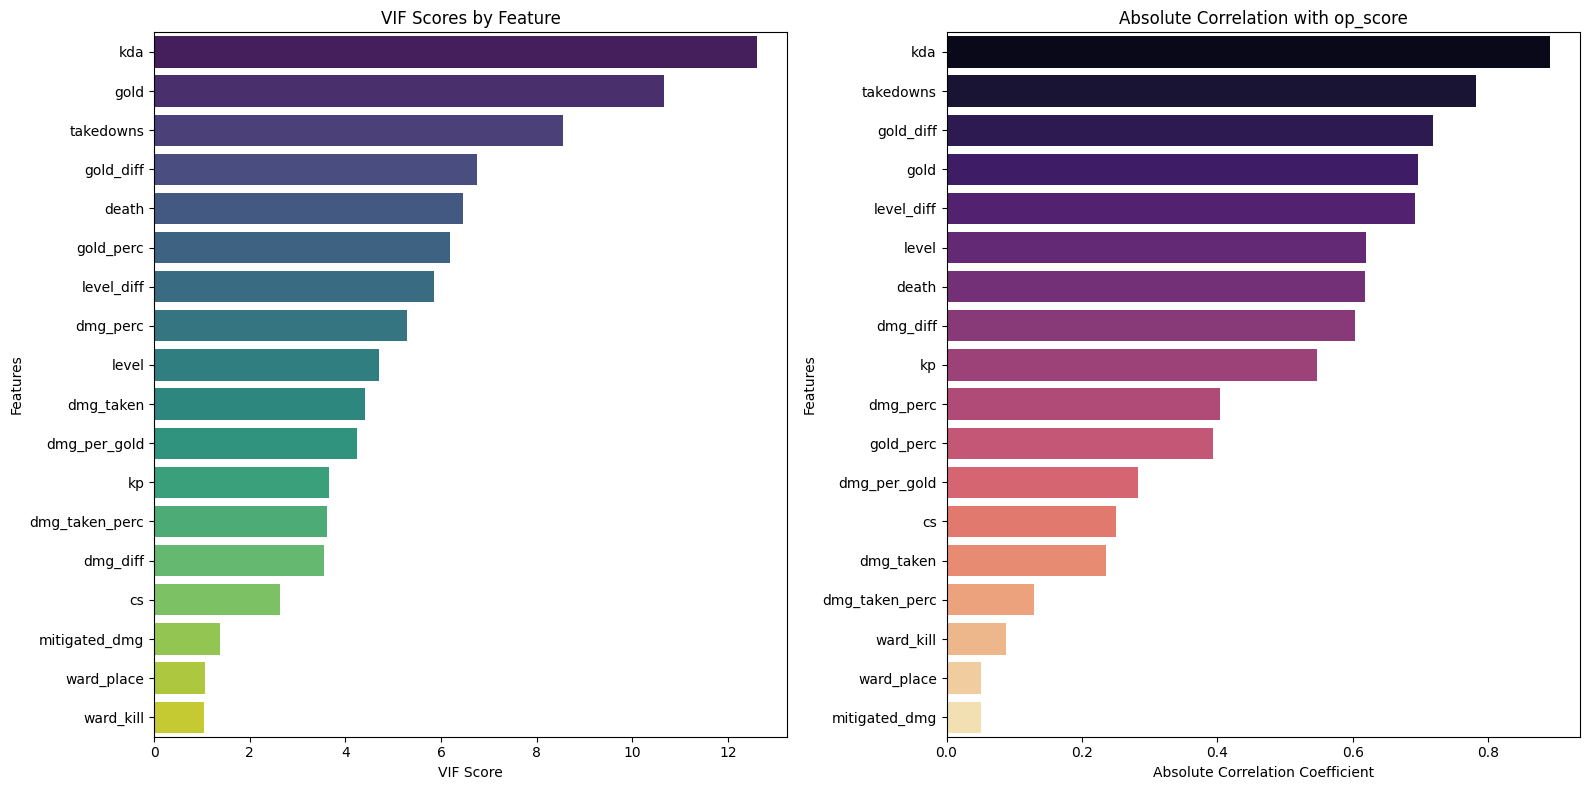

In [180]:
# Assuming 'X' is your features dataframe without 'op_score' and 'df' is the full dataframe
X_const = add_constant(X)

# Calculate VIF and sort
vif = pd.DataFrame()
vif['Feature'] = X_const.columns[1:]  # Exclude the constant from the features
vif['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(1, X_const.shape[1])]  # Start from index 1 to exclude 'const'
vif_sorted = vif.sort_values('VIF', ascending=False)

# Calculate and sort absolute correlation with 'op_score'
correlation_with_op_score = df.drop(['op_score'], axis=1).apply(lambda x: x.corr(df['op_score'])).abs().sort_values(ascending=False)

# Visualizing both VIF and Correlation with op_score using horizontal bars, suppressing warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Horizontal VIF Plot
    sns.barplot(x='VIF', y='Feature', data=vif_sorted, ax=ax[0], palette=sns.color_palette("viridis", len(vif_sorted)))
    ax[0].set_title('VIF Scores by Feature')
    ax[0].set_xlabel('VIF Score')
    ax[0].set_ylabel('Features')

    # Horizontal Correlation Plot
    sns.barplot(x=correlation_with_op_score.values, y=correlation_with_op_score.index, ax=ax[1], palette=sns.color_palette("magma", len(correlation_with_op_score)))
    ax[1].set_title('Absolute Correlation with op_score')
    ax[1].set_xlabel('Absolute Correlation Coefficient')
    ax[1].set_ylabel('Features')

plt.tight_layout()
plt.show()


### Ridge Regression Analysis

After examining the multicollinearity in our dataset through Variance Inflation Factors (VIF) and correlation matrices, we've identified that multicollinearity is definitely affecting the performance and interpretability of our linear regression model. To address this, we are now turning to Ridge Regression, a type of regularization technique that introduces a penalty term to the cost function proportional to the square of the magnitude of the coefficients. 

This approach helps in reducing model complexity and preventing overfitting, which is particularly beneficial in the presence of multicollinearity among features. By adding this penalty, we can shrink the coefficients of less important features toward zero, thus reducing their impact on the model while keeping all features in the model. This can lead to a more robust and generalized model. 

We will tune the hyperparameter alpha, which controls the strength of the penalty, to find the optimal value that minimizes prediction error. Let's proceed with fitting our Ridge Regression model and evaluating its performance.

In [181]:
# Define the parameter grid for alpha
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize and perform grid search to find the best alpha
ridge = Ridge()
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_ridge.fit(X_train, y_train)

# Evaluate the model
best_ridge_model = grid_search_ridge.best_estimator_
y_pred_ridge = best_ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = best_ridge_model.score(X_test, y_test)

print(f'Best Alpha: {grid_search_ridge.best_params_["alpha"]}')
print(f'MSE (Ridge Regression): {mse_ridge}')
print(f'R^2 (Ridge Regression): {r2_ridge}')

# After fitting the Ridge model
ridge_coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_ridge_model.coef_
})

# Considering a small value as threshold for demonstration
ridge_near_zero_threshold = 0.01
near_zero_ridge_features = ridge_coefs[abs(ridge_coefs['Coefficient']) < ridge_near_zero_threshold]['Feature']

print(f"Features with Ridge Coefficients close to zero (|Coefficient| < {ridge_near_zero_threshold}):")
print(near_zero_ridge_features.tolist())



Best Alpha: 0.1
MSE (Ridge Regression): 0.5301821750187043
R^2 (Ridge Regression): 0.8805303295303564
Features with Ridge Coefficients close to zero (|Coefficient| < 0.01):
[]


### Lasso Regression Analysis

Building upon our strategy to mitigate the effects of multicollinearity and further refine our model, we now explore Lasso Regression. Lasso (Least Absolute Shrinkage and Selection Operator) Regression, like Ridge, introduces a regularization penalty to the model. However, the Lasso penalty is proportional to the absolute value of the coefficients, which encourages sparse models where insignificant feature coefficients are driven to exactly zero.

This property of Lasso Regression not only helps in reducing overfitting but also performs feature selection, making it extremely valuable when we suspect that some features may not be important for our prediction task. By effectively removing these features, Lasso simplifies the model, enhancing interpretability and potentially improving model performance by focusing on truly relevant predictors.

We will use cross-validation to select the optimal alpha parameter that leads to the best model performance, balancing model simplicity and predictive accuracy. Let's fit our Lasso Regression model and assess its efficacy.

In [182]:
# Initialize and perform grid search to find the best alpha for Lasso
lasso = Lasso()
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_lasso.fit(X_train, y_train)

# Evaluate the model
best_lasso_model = grid_search_lasso.best_estimator_
y_pred_lasso = best_lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = best_lasso_model.score(X_test, y_test)

print(f'Best Alpha: {grid_search_lasso.best_params_["alpha"]}')
print(f'MSE (Lasso Regression): {mse_lasso}')
print(f'R^2 (Lasso Regression): {r2_lasso}')

# After fitting the Lasso model
lasso_coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_lasso_model.coef_
})

removed_lasso_features = lasso_coefs[lasso_coefs['Coefficient'] == 0]['Feature']

print("Features removed by Lasso (Coefficient = 0):")
print(removed_lasso_features.tolist())


Best Alpha: 0.001
MSE (Lasso Regression): 0.5309697090723502
R^2 (Lasso Regression): 0.8803528689549053
Features removed by Lasso (Coefficient = 0):
[]


### Elastic Net Regression Analysis

As we continue to refine our predictive model, we're exploring Elastic Net Regression, which combines the strengths of both Ridge and Lasso regression. This model is particularly effective in scenarios where there are correlations among the features or when we want to leverage both the feature selection capability of Lasso and the regularization strength of Ridge.

The key advantage of Elastic Net is its flexibility. By adjusting the mix of Lasso and Ridge penalties (through the `l1_ratio` parameter), we can control how much of each penalty is applied, making Elastic Net adaptable to various data characteristics. This can lead to better performance on datasets where neither Lasso nor Ridge alone provides the best solution.

Another benefit of Elastic Net is its ability to handle situations where the number of predictors is much larger than the number of observations, or when several predictors are highly correlated. By combining penalties, it can reduce the risk of overfitting while still performing feature selection, offering a balanced approach to model complexity and predictive power.

Let's implement Elastic Net in our model and observe how it influences our predictions, keeping in mind the goal of minimizing prediction error and identifying the most relevant features.

In [183]:
# ElasticNetCV automatically finds the best alpha and l1_ratio
elastic_net_cv = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], random_state=42)
elastic_net_cv.fit(X_train, y_train)

y_pred_elastic = elastic_net_cv.predict(X_test)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
r2_elastic = elastic_net_cv.score(X_test, y_test)

print(f"MSE (Elastic Net): {mse_elastic}")
print(f"R^2 (Elastic Net): {r2_elastic}")
print(f"Best alpha: {elastic_net_cv.alpha_}")
print(f"Best l1_ratio: {elastic_net_cv.l1_ratio_}")


MSE (Elastic Net): 0.5305011086983313
R^2 (Elastic Net): 0.8804584619659567
Best alpha: 0.0005990547774891991
Best l1_ratio: 0.9


### Polynomial Regression Analysis

Moving beyond linear assumptions, we now explore Polynomial Regression to capture the complex, non-linear relationships between our features and the target variable. This approach allows us to model interactions between variables by introducing polynomial terms (like squared or cubed features) into our regression.

One of the main benefits of Polynomial Regression is its ability to uncover the underlying patterns in data that linear models might miss, offering a more nuanced understanding of the data's behavior. However, it's important to approach Polynomial Regression with caution, as increasing the degree of the polynomial can lead to overfitting. Therefore, we must choose the polynomial degree judiciously, balancing model complexity with generalization to unseen data.

Polynomial Regression shines in its flexibility and capacity to model the curvature and interactions in our data, potentially revealing insights that linear models cannot. By integrating Polynomial Regression into our analysis, we aim to uncover the full spectrum of relationships in our dataset and improve our predictive accuracy.

In [184]:
# Create a polynomial regression model
degree = 2  # You can adjust this to try different degrees of polynomial
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = poly_model.score(X_test, y_test)

print(f"MSE (Polynomial Regression): {mse_poly}")
print(f"R^2 (Polynomial Regression): {r2_poly}")

MSE (Polynomial Regression): 0.431113957096014
R^2 (Polynomial Regression): 0.9028540663644382


### Decision Tree Regression Analysis

We're now turning our attention to Decision Tree Regression, a model that uses a tree-like structure to make predictions. Unlike linear models, Decision Trees can capture non-linear relationships and complex interactions between features without requiring feature scaling or transformation.

A key advantage of Decision Trees is their interpretability; the decision-making process is straightforward to understand and visualize. This makes Decision Trees an attractive option when we value insight into how our predictions are made. Additionally, Decision Trees can handle both numerical and categorical data, providing a versatile tool for various regression tasks.

However, Decision Trees can be prone to overfitting, especially with very deep trees. To counteract this, we may need to prune the tree or combine multiple trees into an ensemble method, like Random Forest, to improve performance and stability.

By adopting Decision Tree Regression, we aim to leverage its interpretability and flexibility, while being mindful of its limitations and employing strategies to mitigate overfitting.


In [185]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

y_pred_tree = tree_reg.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = tree_reg.score(X_test, y_test)

print(f"MSE (Decision Tree): {mse_tree}")
print(f"R^2 (Decision Tree): {r2_tree}")


MSE (Decision Tree): 0.7960609169520548
R^2 (Decision Tree): 0.8206180065961872


### Random Forest Regression Analysis

Building upon the concept of Decision Tree Regression, Random Forest Regression employs an ensemble of decision trees to improve prediction accuracy and control overfitting. This model combines the predictions of several decision trees, each trained on a random subset of the data, to produce a more robust and accurate overall prediction.

The primary benefit of Random Forest is its ability to reduce the variance of individual decision trees, leading to a more stable and reliable model. It's particularly well-suited for dealing with datasets that have a complex structure and a high dimensionality, as it can capture intricate patterns without the need for extensive feature engineering.

Random Forest also provides valuable insights into feature importance, automatically ranking features based on their influence on the predictive accuracy. This can guide us in feature selection and refinement, helping to focus our model on the most impactful variables.

By integrating Random Forest Regression into our analysis, we aim to harness the power of multiple decision trees to enhance our model's accuracy and interpretability, making it a comprehensive tool for tackling our prediction challenges.

In [186]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)

y_pred_forest = forest_reg.predict(X_test)
mse_forest = mean_squared_error(y_test, y_pred_forest)
r2_forest = forest_reg.score(X_test, y_test)

print(f"MSE (Random Forest): {mse_forest}")
print(f"R^2 (Random Forest): {r2_forest}")


MSE (Random Forest): 0.38194207172026656
R^2 (Random Forest): 0.9139343123987459


## Custom Model

## Model Comparison

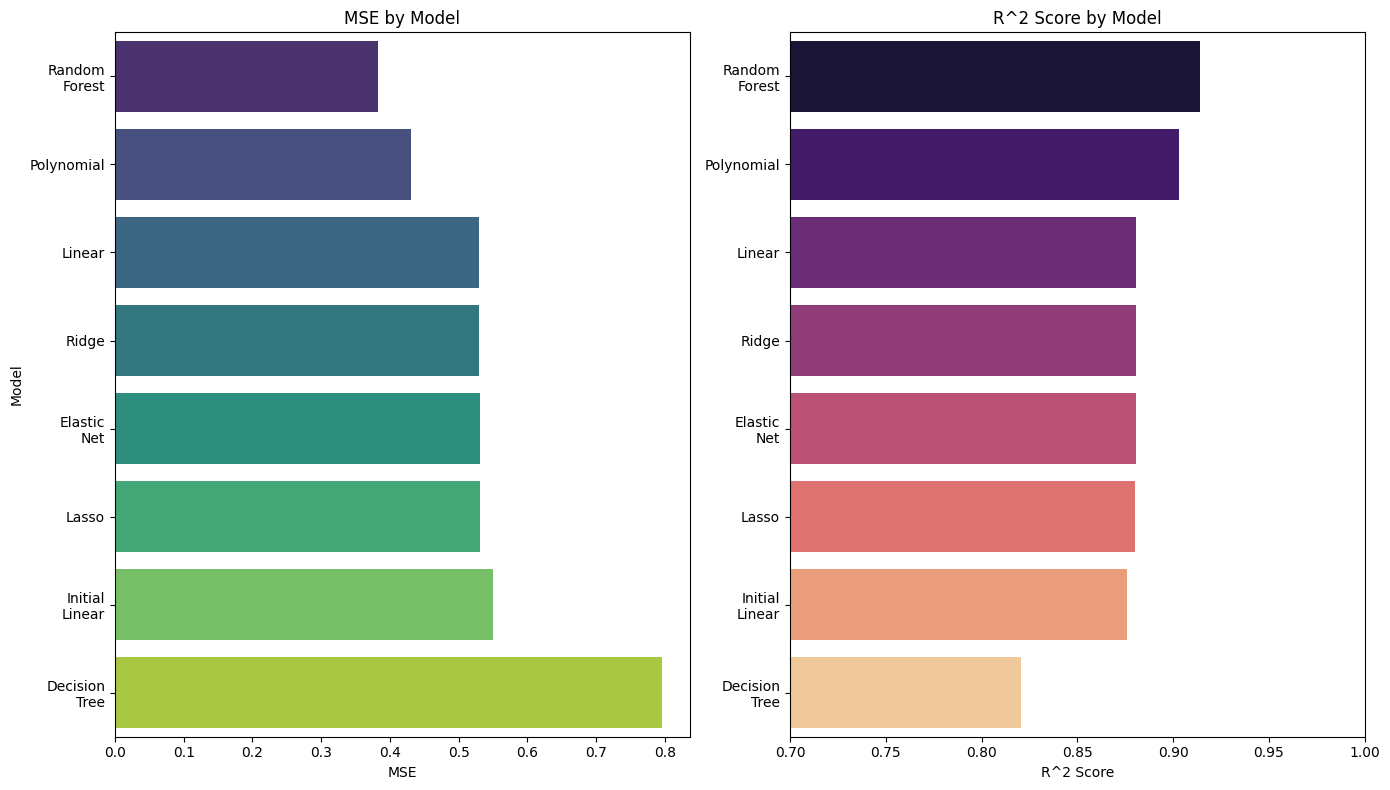

In [187]:
model_names = ['Initial Linear','Linear', 'Ridge', 'Lasso', 'Elastic Net', 'Polynomial', 'Decision Tree', 'Random Forest']
mse_values = [initial_mse, mse_linear, mse_ridge, mse_lasso, mse_elastic, mse_poly, mse_tree, mse_forest]  # MSE values
r2_values = [initial_r2, r2_linear, r2_ridge, r2_lasso, r2_elastic, r2_poly, r2_tree, r2_forest]  # R^2 values

# Sorting values for better visualization
model_names_sorted_by_mse = [x for _, x in sorted(zip(mse_values, model_names), key=lambda pair: pair[0])]
mse_values_sorted = sorted(mse_values)
model_names_sorted_by_r2 = [x for _, x in sorted(zip(r2_values, model_names), reverse=True, key=lambda pair: pair[0])]
r2_values_sorted = sorted(r2_values, reverse=True)

# Convert sorted model names for display
model_names_display_mse = [name.replace(' ', '\n') for name in model_names_sorted_by_mse]
model_names_display_r2 = [name.replace(' ', '\n') for name in model_names_sorted_by_r2]

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 8))

    # Horizontal MSE Plot
    sns.barplot(x=mse_values_sorted, y=model_names_display_mse, ax=ax[0], palette=sns.color_palette("viridis", len(model_names)))
    ax[0].set_title('MSE by Model')
    ax[0].set_xlabel('MSE')
    ax[0].set_ylabel('Model')

    # Horizontal R^2 Plot, starting at 0.5
    sns.barplot(x=r2_values_sorted, y=model_names_display_r2, ax=ax[1], palette=sns.color_palette("magma", len(model_names)))
    ax[1].set_title('R^2 Score by Model')
    ax[1].set_xlabel('R^2 Score')
    ax[1].set_ylabel('')
    ax[1].set_xlim(0.7, 1.0)  # Setting the start of the R^2 graph at 0.5

    plt.tight_layout()
    plt.show()
    plt.show()